In [23]:
#### import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
import pandas as pd
import os 
tf.compat.v1.enable_v2_behavior
# Import tensornetwork
import tensornetwork as tn
# Set the backend to tesorflow
# (default is numpy)
tn.set_default_backend("tensorflow")
batch_size = 128
learning_rate = 0.001
class ClutteredMNISTDataset(Sequence):
    reg_dataset_size = 11276

    def __init__(self, base_path, csv_path, data_scaling=1., num_examples=None, balance=None, num_classes=2):
        self.base_path = base_path
        self.csv_path = csv_path
        self.csv = pd.read_csv(csv_path)
        self.data_scaling = data_scaling
        self.num_examples = num_examples
        self.balance = balance
        self.num_classes = num_classes
        self.img_paths = self.csv['img_path'].values
        self.lbls = self.csv['label'].values.astype(np.int32)
        permute_idx = np.random.permutation(len(self.img_paths))
        self.img_paths = self.img_paths[permute_idx]
        self.lbls = self.lbls[permute_idx]
        self.weights = np.ones([len(self.img_paths), ])

        if self.num_examples is not None and self.balance is not None:
            # only rebalance if examples and balance is given
            assert self.num_examples <= len(self.img_paths), \
                'not enough examples in dataset {} - {}'.format(self.num_examples, len(self.img_paths))

            pos_num = int(self.balance * self.num_examples)
            neg_num = self.num_examples - pos_num

            pos_mask = (self.lbls == 1)
            pos_paths = self.img_paths[pos_mask][:pos_num]

            neg_mask = (self.lbls == 0)
            neg_paths = self.img_paths[neg_mask][:neg_num]

            self.img_paths = np.concatenate([pos_paths, neg_paths], 0)
            self.lbls = np.concatenate([np.ones([pos_num, ]), np.zeros([neg_num, ])], 0)
            self.weights = np.ones([self.num_examples, ])
            self.weights[:pos_num] /= pos_num
            self.weights[pos_num:] /= neg_num

        self.shrinkage = self.reg_dataset_size // len(self.img_paths)
        permute_idx = np.random.permutation(len(self.img_paths))
        self.img_paths = self.img_paths[permute_idx]
        self.lbls = self.lbls[permute_idx]
        
        
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        path = os.path.join(self.base_path, self.img_paths[index])
        lbl = self.lbls[index].astype(np.int64)
        lbl = np.eye(self.num_classes)[lbl].astype(np.int64)
        img = np.load(path)
        if isinstance(img, np.lib.npyio.NpzFile):
            img = img['arr_0']

        if self.data_scaling != 1.:
            img = zoom(img, self.data_scaling)
            img = img.clip(0., 1.)

        img = (img[:,:,np.newaxis].astype(np.float32).astype(np.float32) -0.5)/1

        return img, lbl
    

class Batcher(Sequence):
    """Assemble a sequence of things into a sequence of batches."""
    def __init__(self, sequence, batch_size=16):
        self._batch_size = batch_size
        self._sequence = sequence
        self._idxs = np.arange(len(self._sequence))

    def __len__(self):
        return int(np.ceil(len(self._sequence) / self._batch_size))

    def __getitem__(self, i):
        if i >= len(self):
            raise IndexError("Index out of bounds")

        start = i*self._batch_size
        end = min(len(self._sequence), start+self._batch_size)
        data = [self._sequence[j] for j in self._idxs[start:end]]
        inputs = [d[0] for d in data]
        outputs = [d[1] for d in data]

        return self._stack(inputs), self._stack(outputs)

    def _stack(self, data):
        if data is None:
            return None

        if not isinstance(data[0], (list, tuple)):
            return np.stack(data)

        seq = type(data[0])
        K = len(data[0])
        data = seq(
            np.stack([d[k] for d in data])
            for k in range(K)
        )

        return data

    def on_epoch_end(self):
        np.random.shuffle(self._idxs)
        self._sequence.on_epoch_end()
        
        
        
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_v2_behavior
# Import tensornetwork
import tensornetwork as tn
from tensorflow.keras.utils import to_categorical
tn.set_default_backend("tensorflow")

data_path = '/datacommons/carin/fk43/NeedleinHaystack/mnist64_1/'
train_data=ClutteredMNISTDataset(base_path=data_path, csv_path=os.path.join(data_path, 'train.csv'), data_scaling=1., num_examples=3000, balance=0.5)
val_data = ClutteredMNISTDataset(base_path=data_path, csv_path=os.path.join(data_path, 'val.csv'), data_scaling=1., num_examples=1000, balance=0.5)
test_data = ClutteredMNISTDataset(base_path=data_path, csv_path=os.path.join(data_path, 'test.csv'), data_scaling=1., num_examples=1000, balance=0.5)




In [28]:
train_data.__getitem__(4)[1]

array([0, 1])

In [22]:
train_data = Batcher(train_data, batch_size=batch_size)
val_data = Batcher(val_data, batch_size=batch_size)
test_data = Batcher(test_data, batch_size=batch_size)

In [2]:
dir(train_data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_size',
 '_idxs',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_sequence',
 '_stack',
 'on_epoch_end']

In [6]:
dd = train_data.__getitem__(0)

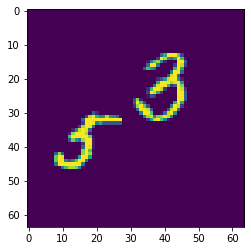

In [7]:
plt.imshow(dd[0][0,:,:,:])

In [8]:
dd[1]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0,